In [1]:
import sys
import numpy as np
import random
import math
from model import W_Net
from eval.eval_by_cropping import eval_model
from Dataset.TrainDatasetConstructor import TrainDatasetConstructor
from Dataset.EvalDatasetConstructor import EvalDatasetConstructor
from metrics import JointLoss, AEBatch, SEBatch
from PIL import Image
import time
import torch
# torch.backends.cudnn.benchmark=True
%matplotlib inline

In [2]:
# config
config = {
'SHANGHAITECH': 'A',
'min_RATE':10000000,
'min_MAE':10240000,
'min_MSE':10240000,
'eval_num':182,
'train_num':300,
'learning_rate': 1e-4,
'train_batch_size': 10,
'epoch': 10000,
'eval_per_step': 150,
'mode':'crop'
}
img_dir = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/train_data/images"
gt_dir = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/train_data/gt_map_w_net"
binary_dir = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/train_data/blur_map_w_net"
img_dir_t = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/test_data/images"
gt_dir_t = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/test_data/gt_map_w_net"
binary_dir_t = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/test_data/blur_map_w_net"
model_save_path = "/home/zzn/PycharmProjects/W-Net_pytorch/checkpoints/model_w_net.pkl"

In [3]:
# data_load
train_dataset = TrainDatasetConstructor(img_dir, gt_dir, binary_dir, config['train_num'], mode=config['mode'], if_random_hsi=True, if_flip=True)
eval_dataset = EvalDatasetConstructor(img_dir_t, gt_dir_t, config['eval_num'], mode=config['mode'])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config['train_batch_size'])
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [ ]:
# obtain the gpu device
assert torch.cuda.is_available()
cuda_device = torch.device("cuda")

# model construct
net = W_Net().cuda()
# net = torch.load("/home/zzn/PycharmProjects/W-Net_pytorch/checkpoints/model_w_net.pkl")
# set optimizer and estimator

optimizer_1 = torch.optim.Adam(net.parameters(), config['learning_rate'], weight_decay=5e-3)
optimizer_2 = torch.optim.Adam(net.parameters(), config['learning_rate'], weight_decay=5e-3)
# criterion = JointLoss(alpha=100000, beta=6).cuda()
criterion_mseloss = torch.nn.MSELoss(size_average=False).cuda()
criterion_bceloss = torch.nn.BCELoss(size_average=True).cuda()
ae_batch = AEBatch().cuda()
se_batch = SEBatch().cuda()
modules = {'model':net, 'ae':ae_batch, 'se':se_batch}

/home/zzn/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/zzn/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


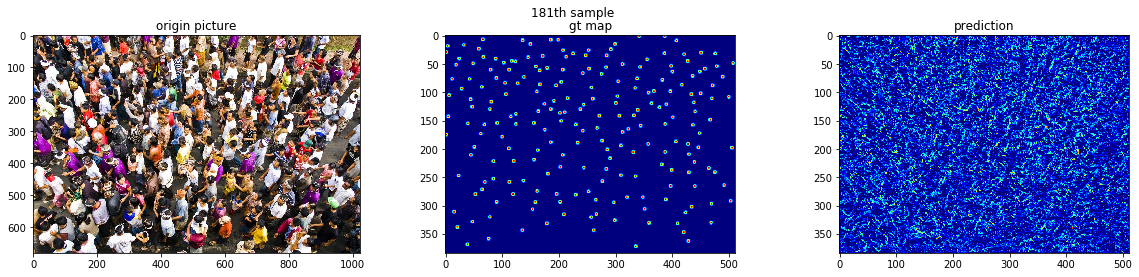

The gt counts of the above sample:215.5531005859375, and the pred counts:1.02131187915802
In step 0, epoch 1,  MAE = 431.7414245605469, MSE = 557.397216796875, time cost eval = 25.34807825088501s

 In epoch 0, the mseloss = -1, the bceloss = 9.882708867390951,, time_cost = 17.029786825180054s

 In epoch 1, the mseloss = 62.35622316996257, the bceloss = -1,, time_cost = 17.056107759475708s

 In epoch 2, the mseloss = 40.27254479726155, the bceloss = -1,, time_cost = 17.047976970672607s

 In epoch 3, the mseloss = 38.11234423319499, the bceloss = -1,, time_cost = 17.063900232315063s

 In epoch 4, the mseloss = 37.397906112670896, the bceloss = -1,, time_cost = 17.0321364402771s


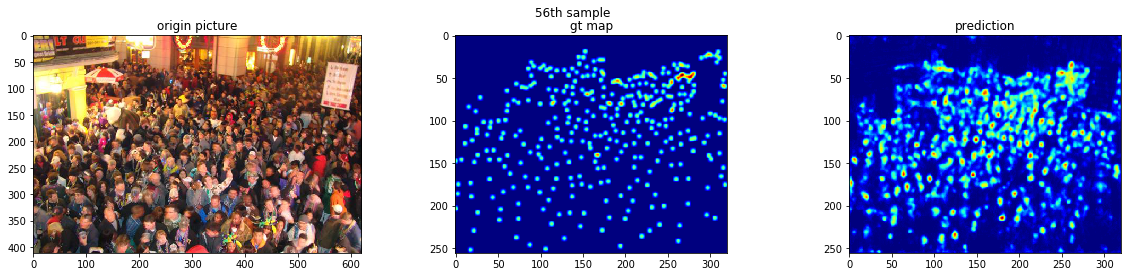

The gt counts of the above sample:347.8106689453125, and the pred counts:334.2159118652344
In step 150, epoch 6,  MAE = 145.8640594482422, MSE = 205.0990447998047, time cost eval = 23.319445848464966s

 In epoch 5, the mseloss = -1, the bceloss = 8.622657378514608,, time_cost = 17.046652793884277s


In [ ]:
step = 0
# torch.cuda.empty_cache()
for epoch_index in range(config['epoch']):
    dataset = train_dataset.shuffle()
    mse_loss_list = []
    bce_loss_list = []
    time_per_epoch = 0
    
    if epoch_index == 50:
        config['eval_per_step'] = 30
    
    for train_img_index, train_img, train_gt, train_binary in train_loader:
        if step % config['eval_per_step'] == 0:
            validate_MAE, validate_RMSE, time_cost = eval_model(config, eval_loader, modules, True)
            
            sys.stdout.write('In step {}, epoch {},  MAE = {}, MSE = {}, time cost eval = {}s\n'.format(step, epoch_index + 1, validate_MAE, validate_RMSE, time_cost))
            sys.stdout.flush()
            
#             save model
            if config['min_MAE'] > validate_MAE:
                config['min_MAE'] = validate_MAE
                torch.save(net, model_save_path)
#             torch.save(net, "/home/zzn/Downloads/CSRNet_pytorch-master/checkpoints/model_in_time.pkl")
            
            # return train model
        net.train()
        torch.cuda.empty_cache()
        
#         loss = criterion(prediction, y, z)
        if epoch_index % 5 == 0:
            optimizer_2.zero_grad()
            # B
            x = train_img
            y = train_gt
            z = train_binary
            start = time.time()
            prediction = net(x)
            loss = criterion_bceloss(prediction, z) * 5
            bce_loss_list.append(loss.data.item())
            loss.backward()
            optimizer_2.step()
        
        else:
            optimizer_1.zero_grad()
                # B
            x = train_img
            y = train_gt
            z = train_binary
            start = time.time()
            prediction = net(x)
            loss = criterion_mseloss(prediction, y)
            mse_loss_list.append(loss.data.item())
            loss.backward()
            optimizer_1.step()
        step += 1
        torch.cuda.synchronize()
        end2 = time.time()
#         if step == 400 * 100 or step == 400 * 1000 or step == 400 * 500:
#             config['eval_per_step'] = eval_steps_adaptive(step)
        time_per_epoch += end2 - start
    if len(mse_loss_list) > 0:
        epoch_mse_loss = np.mean(mse_loss_list)
    else:
        epoch_mse_loss = -1
    if len(bce_loss_list) > 0:
        epoch_bce_loss = np.mean(bce_loss_list)
    else:
        epoch_bce_loss = -1
    sys.stdout.write('\n In epoch {}, the mseloss = {}, the bceloss = {},, time_cost = {}s\n'.format(epoch_index, epoch_mse_loss, epoch_bce_loss, time_per_epoch))
    sys.stdout.flush()

In [6]:
torch.save(net, "/home/zzn/PycharmProjects/W-Net_pytorch/checkpoints/model_w_net.pkl")

In [4]:
# print((10 * 3 * 400 * 400 * 4 + 9 * 3 * 384 * 512) / 1024/1024)
# print(17001922 * 4 / 1024 / 1024) 97 -25 = 72 169 - 97 = 72
# print(768 * 1024 / 400 / 400)
import numpy as np
tmp_maps = []
tmp_maps.append(768 * 1024 * 64 * 4 * 2 / 1024 / 1024)
tmp_maps.append(384 * 512 * 128 * 4 * 2 / 1024 / 1024)
tmp_maps.append(192 * 256 * 256 * 4 * 3 / 1024 / 1024)
tmp_maps.append(96 * 128 * 512 * 4 * 3 / 1024 / 1024)
tmp_maps.append(48 * 64 * 512 * 4 * 3 / 1024 / 1024)
print(np.sum(tmp_maps))
print(96 * 128 * 1024 * 4 / 1024 / 1024 )
print(96 * 128 * 256 * 4 * 2/ 1024 / 1024 )
print(tmp_maps[0])
print(384 * 2)

810.0
48.0
24.0
384.0
768


In [ ]:
b = torch.randn(10, 3, 400, 400).cuda()
net = W_Net().cuda()
c = net(b)
# a = torch.randn(1, 3, 768, 1024).cuda()
# b = torch.randn(9, 3, 384, 512).cuda()
# with torch.no_grad():
#     c = net(b)
#     torch.cuda.empty_cache()
# params = net.parameters()

In [4]:
# net = torch.load("/home/zzn/PycharmProjects/W-Net_pytorch/checkpoints/model_w_net.pkl")
net = W_Net().cuda()
criterion = JointLoss(alpha=100000, beta=10).cuda()
for train_img_index, train_img, train_gt, train_binary in train_loader:
    x = train_img
    y = train_gt
    z = train_binary
    start = time.time()
    prediction = net(x)
    loss = criterion(prediction, y, z)


/home/zzn/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


tensor(0.3582, device='cuda:0', grad_fn=<MulBackward0>) tensor(46.8459, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([10, 1, 200, 200])
tensor(-0.0048, device='cuda:0', grad_fn=<MeanBackward1>)
